In [19]:
import requests
import time
import statistics
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set DPI for print and civilised computers:
mpl.rcParams['figure.dpi']= "300"

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

# Get the IP number of the master
#MASTER_IP = ! openstack stack output show \
#    project-group-x-stack \
#    master_instance_floating_ip \
#    --format=value \
#    --column=output_value

# MASTER_IP = "127.0.0.1"

API_BASE_URL = "http://{}:5000".format(MASTER_IP)
POLL_INTERVAL_S = 0.5
FILES_PER_TASK = 4

## Calling the API from Python


The following sequence illustrates how to make a blocking call to the asynchronous API using Python and requests:

In [96]:
def submit_experiment(**kwargs):
    session = requests.Session()
    job = session.post("{}/experiments".format(API_BASE_URL), json=kwargs)
    job.raise_for_status()
    print(job.url)
    return job.url
            
def get_status(job_callback_url, session=None):
    session = requests.Session() if not session else session
    res = session.get(job_callback_url)
    res.raise_for_status()
    return res.json()

def poll_job(job_callback_url):
    session = requests.Session()
    try:
        job_status = get_status(job_callback_url, session)
    except requests.HTTPError:
        job_status = {'status': 'nothing'}
    
    while job_status['status'] != 'COMPLETED':
        job_status = get_status(job_callback_url, session)
        time.sleep(POLL_INTERVAL_S)
    return job_status

In [97]:
def runtimes(results):
    return [result['runtime'] for result in results]

In [107]:
NR_WORKERS = requests.get("{}/config/workers".format(API_BASE_URL)).json()
NR_WORKERS

5

## Performance Benchmark

In [133]:
WORKERS_RANGE = list(range(1, NR_WORKERS + 1))
SCALE_PER_WORKER = 1
START_SCALE = 1
# Repeat each experiment:
NR_SAMPLES = 1

def set_nr_workers(n):
    try:
        res = requests.put("{}/config/workers/{}"
                            .format(API_BASE_URL, n))
        res.raise_for_status()
    except Exception:
        #print("Warning! Problem setting workers to {}"
        #      .format(n))
        # This is a really cheap and dirty retry logic
        set_nr_workers(n)

def run_benchmark(nr_workers, nr_jobs):
    set_nr_workers(nr_workers)
    time.sleep(0.5) # Wait for things to settle
    
    def do_measure():
        start_time = time.time()
        
        urls = [submit_experiment(
                    benchmarks=["square.smt2"],
                    timeout=10,
                    approximations=["ijcar"],
                    solvers=["backeman/uppsat:z3"]) 
                for _ in range(nr_jobs)]
        
        # Wait for jobs to finish
        trial_runtimes = sum([runtimes(poll_job(url)['results']) 
                              for url in urls], [])
        
        return (time.time() - start_time, trial_runtimes)
    
    results = [do_measure() for _ in range(NR_SAMPLES)]
    
    #print("Variance was: {}".format(
    #    statistics.variance(results)))
    (runtime, solver_runtimes) = zip(*results)
    
    # Flatten any repeated solver runtime trials
    solver_runtimes = sum(list(solver_runtimes), []) 
    print("Workers: {}, nr jobs: {} had runtime {}".format(nr_workers, nr_jobs, runtime))
    print("Solver runtimes were: {}".format(solver_runtimes))
    return (statistics.mean(runtime), solver_runtimes)

def scale_workload(nr_workers):
    return START_SCALE + (nr_workers * SCALE_PER_WORKER)

In [127]:
weak_scaling_runtimes = zip(*[run_benchmark(
                                nr_workers, 
                                nr_jobs=scale_workload(nr_workers))
                                    for nr_workers in WORKERS_RANGE])[0]

http://127.0.0.1:5000/experiments/1a40e6f5-d0c6-4c6a-a6f0-fa0c3ebab34a
http://127.0.0.1:5000/experiments/4a484a67-68bc-4dcc-92e5-f18be03964e0
Workers: 1, nr jobs: 2 had runtime (14.622241020202637,)
Solver runtimes were: ([1.983016, 2.025624],)
http://127.0.0.1:5000/experiments/18a9bd80-a62f-463b-ae68-135de503103a
http://127.0.0.1:5000/experiments/3b98ef99-14ca-4c04-a764-537dafbb7332
http://127.0.0.1:5000/experiments/e8b291b9-dc90-4405-bdd9-b317efe30a8b
Workers: 2, nr jobs: 3 had runtime (15.982510089874268,)
Solver runtimes were: ([2.060298, 2.182729, 1.93023],)
http://127.0.0.1:5000/experiments/e6925f57-dcc6-46f3-bae7-25c97225b440
http://127.0.0.1:5000/experiments/13fe0c8b-f4f8-440f-a244-0cedf631091b
http://127.0.0.1:5000/experiments/236c4459-1a77-4b6b-b56c-bdb05d56c6cb
http://127.0.0.1:5000/experiments/48390925-ef99-4ad7-927b-ba8c0b47ce89
Workers: 3, nr jobs: 4 had runtime (15.038697957992554,)
Solver runtimes were: ([2.347081, 2.360694, 2.264269, 2.032382],)
http://127.0.0.1:5000/e

In [ ]:
STRONG_SCALING_NR_JOBS = 1
strong_scaling_runtimes, solve_times = zip(*[
        run_benchmark(nr_workers, nr_jobs=STRONG_SCALING_NR_JOBS)
            for nr_workers in WORKERS_RANGE])

http://127.0.0.1:5000/experiments/50224b29-326d-4a52-a5a4-c11a762cddd9
Workers: 1, nr jobs: 1 had runtime (7.719134092330933,)
Solver runtimes were: [2.076334]
http://127.0.0.1:5000/experiments/2a328791-0ef1-47cc-b843-3f7fa7606da8
Workers: 2, nr jobs: 1 had runtime (7.722869157791138,)
Solver runtimes were: [2.011874]
http://127.0.0.1:5000/experiments/d2dd4daa-9af4-45f5-86eb-8cf5c26f06cc


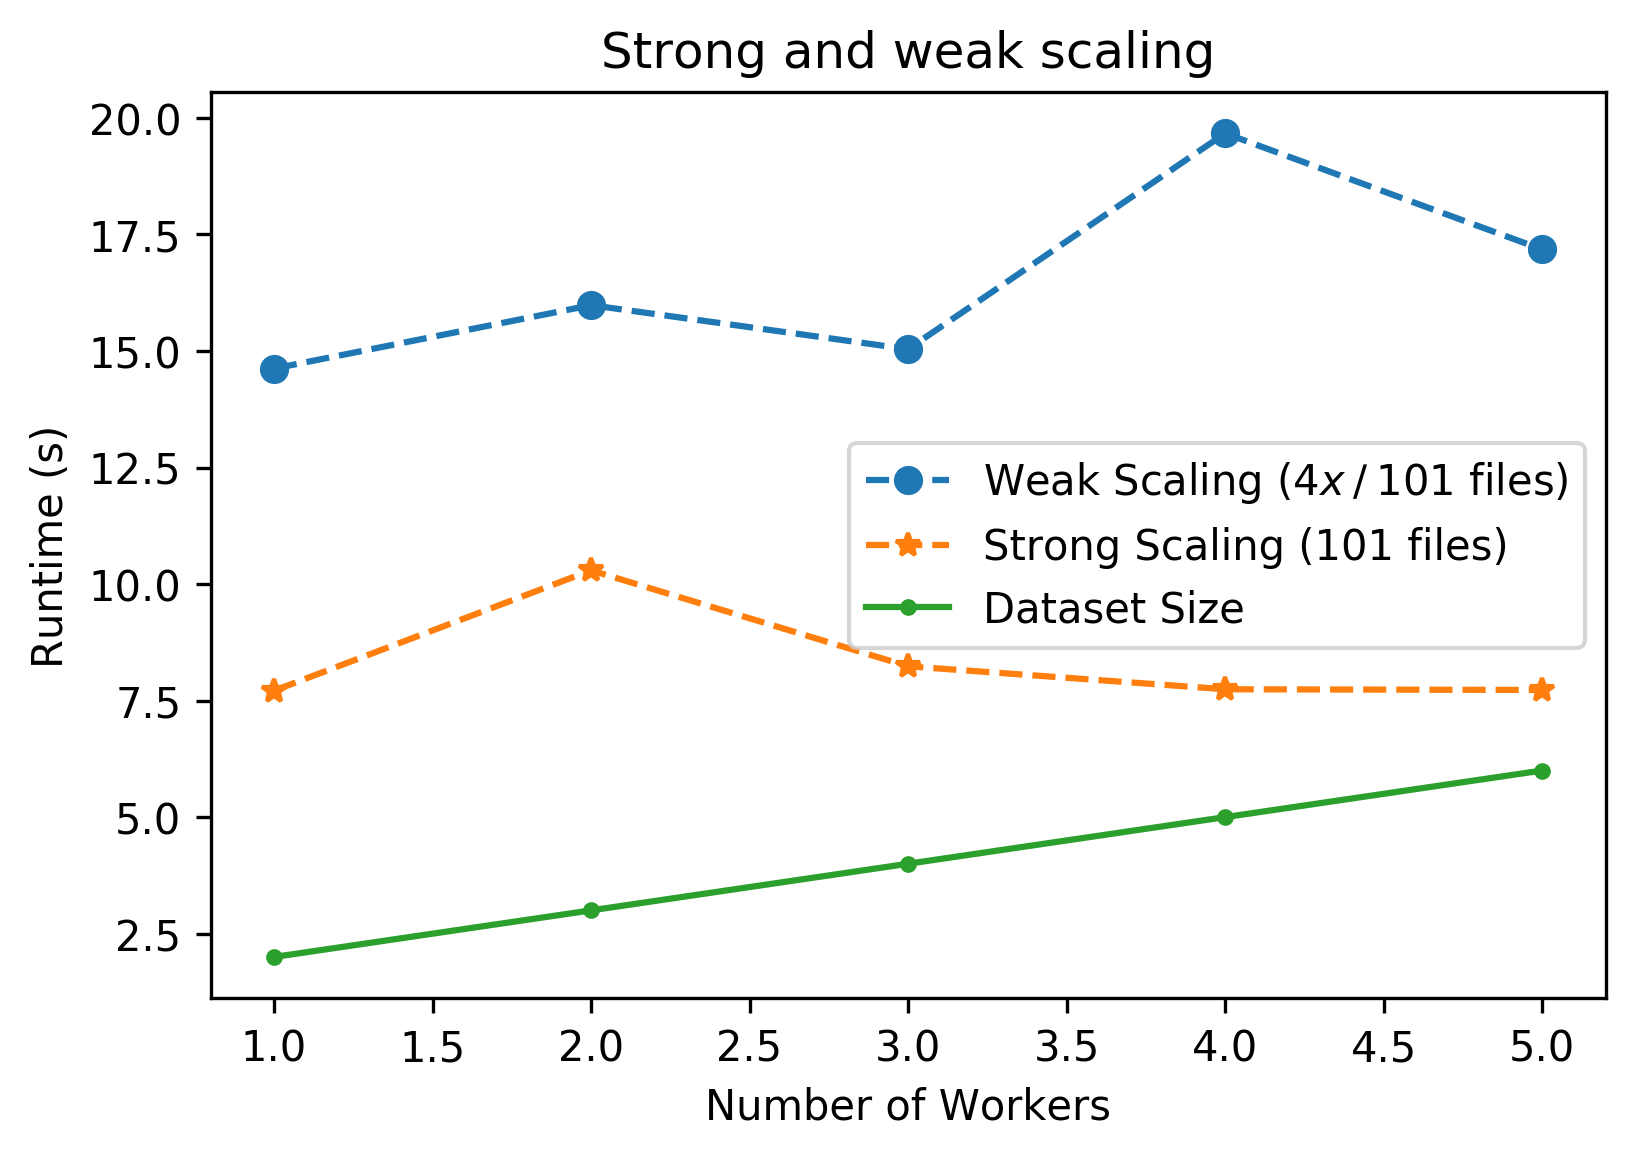

In [129]:
SCALING_MULTIPLIER = FILES_PER_TASK * SCALE_PER_WORKER

plt.plot(
    WORKERS_RANGE, 
    weak_scaling_runtimes,
    marker='o',
    linestyle='dashed',
    label=("Weak Scaling (${}x\: \slash\: 101$ files)"
            .format(SCALING_MULTIPLIER)))

plt.plot(WORKERS_RANGE, 
         strong_scaling_runtimes,
         marker='*',
         linestyle='dashed',
         label="Strong Scaling (101 files)")

plt.plot(WORKERS_RANGE, 
         [scale_workload(x) for x in WORKERS_RANGE],
         marker='.',
         linestyle=None,
         label="Dataset Size")

# Error bars are there for completeness;
# in practice, they will be all but invisible.
#plt.errorbar(WORKERS_RANGE, 
#             weak_scaling_runtimes, 
#             xerr=0, 
#             yerr=POLL_INTERVAL_S,
#             fmt='.')

#plt.errorbar(WORKERS_RANGE, 
#             strong_scaling_runtimes, 
#             xerr=0, 
#             yerr=POLL_INTERVAL_S,
#             fmt='.')

plt.ylabel('Runtime (s)')
plt.xlabel('Number of Workers')
plt.title("Strong and weak scaling")
plt.legend()
plt.show()